In [1]:
!pip3 install kaggle

In [2]:
import os
import json 

with open('kaggle.json') as f:
    kaggle = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle['username']
os.environ['KAGGLE_KEY'] = kaggle['key']

In [ ]:
# don't run unless in colab
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [7]:
class GTSRBDataset(datasets.ImageFolder):
    def __init__(self, csv_file, img_dir, transform=None):
        self.csv_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {int(row['ClassId']): row['Path'].split('/')[0] for _, row in self.csv_data.iterrows()}

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.csv_data.iloc[index]['Path'])
        image = datasets.folder.default_loader(img_path)
        label = int(self.csv_data.iloc[index]['ClassId'])

        if self.transform:
            image = self.transform(image)

        return image, label

# Defined transformations
transformations = transforms.Compose([
    transforms.Resize((299, 299)), # InceptionV3 expects 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

base_dir = 'gtsrb-german-traffic-sign'  # Adjust this path as necessary
train_data = GTSRBDataset(csv_file=os.path.join(base_dir, 'Train.csv'), img_dir=base_dir, transform=transformations)
test_data = GTSRBDataset(csv_file=os.path.join(base_dir, 'Test.csv'), img_dir=base_dir, transform=transformations)

# train val split
train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_data, [train_size, valid_size])

# Dataloaders for train val test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


In [9]:
# Load pretrained Inception V3 model 
model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 43)  # GTSRB has 43 classes

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer weights and biases to allow gradients to be calculated
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model = model.to(device)


In [10]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc="Training", unit="batch")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Handling aux logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
    return running_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    pbar = tqdm(loader, desc="Validating", unit="batch")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix(loss=loss.item())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(loader), f1, accuracy

def test_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    pbar = tqdm(loader, desc="Testing", unit="batch")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix(loss=loss.item())
    test_loss = running_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    return test_loss, f1, accuracy


In [11]:
# Training the model
num_epochs = 25
train_losses, valid_losses, valid_f1s, valid_accuracies = [], [], [], []
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, f1, accuracy = validate(model, valid_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_f1s.append(f1)
    valid_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}')



Validating:   0%|          | 0/62 [00:50<?, ?batch/s, loss=1.45]


Epoch 1, Train Loss: 1.9979, Valid Loss: 1.3053, F1: 0.6455, Accuracy: 0.6663


Validating:   0%|          | 0/62 [00:50<?, ?batch/s, loss=1.09] 


Epoch 2, Train Loss: 1.2123, Valid Loss: 1.0068, F1: 0.7177, Accuracy: 0.7281


Validating:   0%|          | 0/62 [00:50<?, ?batch/s, loss=0.963]


Epoch 3, Train Loss: 1.0104, Valid Loss: 0.8701, F1: 0.7497, Accuracy: 0.7548


Validating:   0%|          | 0/62 [00:50<?, ?batch/s, loss=0.858]


Epoch 4, Train Loss: 0.9166, Valid Loss: 0.7771, F1: 0.7735, Accuracy: 0.7789


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.733]


Epoch 5, Train Loss: 0.8644, Valid Loss: 0.7110, F1: 0.7960, Accuracy: 0.7986


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.781]


Epoch 6, Train Loss: 0.8246, Valid Loss: 0.6976, F1: 0.7947, Accuracy: 0.7964


Validating:   0%|          | 0/62 [00:48<?, ?batch/s, loss=0.678]


Epoch 7, Train Loss: 0.7970, Valid Loss: 0.6608, F1: 0.8036, Accuracy: 0.8057


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.693]


Epoch 8, Train Loss: 0.7803, Valid Loss: 0.6304, F1: 0.8144, Accuracy: 0.8162


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.71] 


Epoch 9, Train Loss: 0.7641, Valid Loss: 0.6175, F1: 0.8134, Accuracy: 0.8162


Validating:   0%|          | 0/62 [00:50<?, ?batch/s, loss=0.607]


Epoch 10, Train Loss: 0.7456, Valid Loss: 0.5969, F1: 0.8179, Accuracy: 0.8192


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.674]


Epoch 11, Train Loss: 0.7422, Valid Loss: 0.5701, F1: 0.8218, Accuracy: 0.8235


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.579]


Epoch 12, Train Loss: 0.7309, Valid Loss: 0.5683, F1: 0.8230, Accuracy: 0.8245


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.637]


Epoch 13, Train Loss: 0.7297, Valid Loss: 0.5582, F1: 0.8281, Accuracy: 0.8303


Validating:   0%|          | 0/62 [00:48<?, ?batch/s, loss=0.626]


Epoch 14, Train Loss: 0.7337, Valid Loss: 0.5776, F1: 0.8098, Accuracy: 0.8127


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.65] 


Epoch 15, Train Loss: 0.7205, Valid Loss: 0.5483, F1: 0.8325, Accuracy: 0.8332


Validating:   0%|          | 0/62 [00:48<?, ?batch/s, loss=0.641]


Epoch 16, Train Loss: 0.7150, Valid Loss: 0.5447, F1: 0.8251, Accuracy: 0.8267


Validating:   0%|          | 0/62 [00:50<?, ?batch/s, loss=0.549]


Epoch 17, Train Loss: 0.7130, Valid Loss: 0.5363, F1: 0.8325, Accuracy: 0.8333


Validating:   0%|          | 0/62 [00:48<?, ?batch/s, loss=0.588]


Epoch 18, Train Loss: 0.7138, Valid Loss: 0.5430, F1: 0.8265, Accuracy: 0.8276


Validating:   0%|          | 0/62 [00:51<?, ?batch/s, loss=0.55] 


Epoch 19, Train Loss: 0.7089, Valid Loss: 0.5301, F1: 0.8326, Accuracy: 0.8330


Validating:   0%|          | 0/62 [00:50<?, ?batch/s, loss=0.564]


Epoch 20, Train Loss: 0.7102, Valid Loss: 0.5290, F1: 0.8278, Accuracy: 0.8291


Validating:   0%|          | 0/62 [00:50<?, ?batch/s, loss=0.55] 


Epoch 21, Train Loss: 0.7036, Valid Loss: 0.5491, F1: 0.8217, Accuracy: 0.8226


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.529]


Epoch 22, Train Loss: 0.7050, Valid Loss: 0.5263, F1: 0.8323, Accuracy: 0.8331


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.619]


Epoch 23, Train Loss: 0.6987, Valid Loss: 0.5198, F1: 0.8302, Accuracy: 0.8322


Validating:   0%|          | 0/62 [00:48<?, ?batch/s, loss=0.494]


Epoch 24, Train Loss: 0.6989, Valid Loss: 0.4981, F1: 0.8410, Accuracy: 0.8424


Validating:   0%|          | 0/62 [00:49<?, ?batch/s, loss=0.586]

Epoch 25, Train Loss: 0.6974, Valid Loss: 0.5275, F1: 0.8277, Accuracy: 0.8291


In [12]:
# Testing the model
test_loss, test_f1, test_accuracy = test_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}')

Testing:   0%|          | 0/99 [01:19<?, ?batch/s, loss=0.942]

Test Loss: 1.0048, Test F1: 0.6852, Test Accuracy: 0.6956


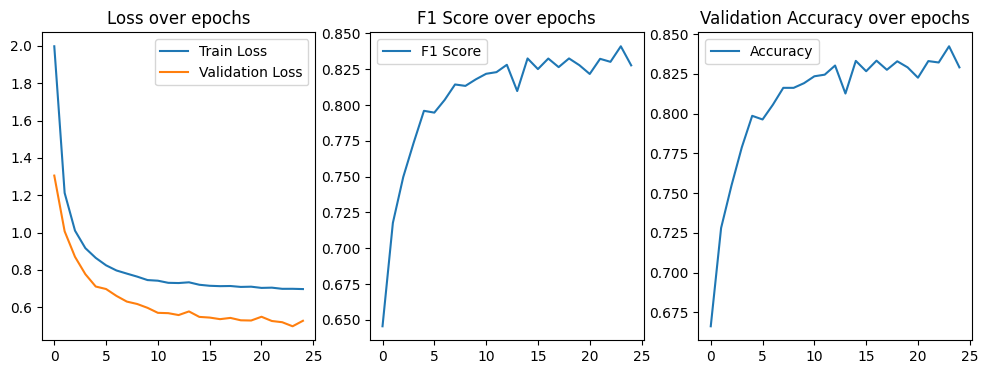

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 3, 2)
plt.plot(valid_f1s, label='F1 Score')
plt.legend()
plt.title('F1 Score over epochs')

plt.subplot(1, 3, 3)
plt.plot(valid_accuracies, label='Accuracy')
plt.legend()
plt.title('Validation Accuracy over epochs')
plt.show()


In [14]:
# Save the model's state dictionary and the optimizer's state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'inceptionV3_finetuned_GTSRB.pth')

print("Model and optimizer states have been saved.")


Model and optimizer states have been saved.


In [18]:

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np

stop_sign_id = 14  # Class ID for stop signs
y_true = []
y_pred = []

model.eval()  
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)  
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Append only results for stop signs
        mask = (labels == stop_sign_id)
        y_true.extend(labels[mask].tolist())
        y_pred.extend(predicted[mask].tolist())

# Convert to binary classification: 1 if stop sign, 0 otherwise
y_true_binary = [1 if x == stop_sign_id else 0 for x in y_true]
y_pred_binary = [1 if x == stop_sign_id else 0 for x in y_pred]

# Metrics calculation
precision, recall, f_score, _ = precision_recall_fscore_support(y_true_binary, y_pred_binary, average='binary')
cm = confusion_matrix(y_true_binary, y_pred_binary)
cm_df = pd.DataFrame(cm, index=["Not Stop Sign", "Stop Sign"], columns=["Not Stop Sign", "Stop Sign"])

print(f"Precision for Stop Signs: {precision:.4f}")
print(f"Recall for Stop Signs: {recall:.4f}")
print(f"F-Score: {f_score:.4f}")
print("Confusion Matrix for Stop Signs:")
print(cm_df)


Precision for Stop Signs: 1.0000
Recall for Stop Signs: 0.9148
F-Score: 0.9555
Confusion Matrix for Stop Signs:
               Not Stop Sign  Stop Sign
Not Stop Sign              0          0
Stop Sign                 23        247
